In [1]:
import cogent3
from cogent3 import get_app
import matplotlib.pyplot as plt
import paths
import libs

# CDS

I sampled chromosome 22 cds using 
```
eti homologs -i install/ --outdir cds --ref human --coord_names 22 
```
Then I trim stop codons and use a codon alignment model for all the sequences using
```
trim_stops = get_app("trim_stop_codons")
codon_align = get_app("progressive_align", "codon", guide_tree="(Human:0.06,Chimpanzee:0.06,Gorilla:0.1)")
```
I store the aligned sequences in the folder cds/codon_aligned/

In [2]:
folder_in = paths.DATA_APES114 + 'cds/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           396
not_completed         0
logs                  1
-----------------------


In [3]:
loader = get_app("load_aligned", moltype="dna")   
omit_degs_cds = get_app("omit_degenerates", moltype="dna", motif_length=3)
rename_cds = libs.renamer_cds_aligned()
ffold = get_app("take_codon_positions", fourfold_degenerate=True)
concat = get_app("concat", moltype="dna")

#create a concatenated alignment with all coding positions
ffold_process = loader + omit_degs_cds + rename_cds + ffold
# result below is only valid alignments (no NotCompleted).
results_ffold = [r for r in ffold_process.as_completed(in_dstore[:], parallel=True) if r]
ffold_alns = concat(results_ffold)
ffold_alns.source = "cds_alignments"

ffold_alns

   0%|          |00:00<?

,0
Chimpanzee,TTCTTTCAGCGCGTCTGGCATGCGAATGCTCCCACGGTACCCCGAATGCGGTGGGGCCCC
Gorilla,......................................................A.....
Human,............................................................


In [4]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_ffold = sm(ffold_alns)
print("Model results : \n" + str(result_ffold.lf) + "\n")

print("Distances: ")
lengthstree_ffold = result_ffold.lf.get_lengths_as_ens()
humanENS_ffold = lengthstree_ffold["Human"]
print(lengthstree_ffold)

   0%|          |00:00<?

   0%|          |00:00<?

Model results : 
GN
log-likelihood = -45816.4312
number of free parameters = 39
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Chimpanzee    root        0.01    0.96    7.98    1.49    1.59    1.53
Gorilla       root        0.01    0.95    3.17    0.42    0.73    0.92
Human         root        0.01    1.09    4.40    0.26    0.58    0.88
----------------------------------------------------------------------

continued: 
  C>T      G>A     G>C     G>T     T>A      T>C
-----------------------------------------------
12.90    15.42    1.28    1.90    0.00    10.17
 4.53     5.64    1.27    0.41    0.49     4.27
 6.88     8.39    1.28    0.72    0.24     2.88
-----------------------------------------------

   A       C       G       T
----------------------------
0.14    0.39    0.32    0.15
----------------------------

Distances: 
{'Chimpanzee': np.float64(0.007198678541013248), 'Gorilla': np.

In [5]:
totalENS_ffold = result_ffold.total_length(length_as="ENS")
totalENS_ffold

np.float64(0.027465077071970587)

# Introns

I sampled chromosome 22 introns masking ancestral repeats and cds using 
```
eti alignments -i install -od introns --align_name 10_primates* --ref human --mask cds_allAR_1column.txt --coord_names 22 
```
where cds_allAR_1column.txt is a list containing all the biotypes for ancestral repeats and cds

In [6]:
folder_in = paths.DATA_APES114 + 'introns/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           543
not_completed         0
logs                  1
-----------------------


In [7]:
#loading and cocatanating sequences
loader = get_app("load_aligned", moltype="dna")
omit_degs_noncds1 = get_app("omit_degenerates", moltype="dna")
rename_noncds = libs.renamer_noncds_aligned()
concat = get_app("concat", moltype="dna")

noncds_app = loader + omit_degs_noncds1 + rename_noncds
#By using this renamer_aligned function I throw away sequences with paralogs
results_allpos = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_introns = concat(results_allpos)
alns_introns.source = "introns_alignments"
alns_introns

   0%|          |00:00<?

,0
Chimpanzee,GATAATAAACGTCTCATAATCAATTCATGGTTTAGTCACACAAGCGCCTATAAATCCCAA
Gorilla,.................................................G..........
Human,............................................................


In [8]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_introns = sm(alns_introns)
print("Model results : \n" + str(result_introns.lf) + "\n")

print("Distances: ")
lengthstree_introns = result_introns.lf.get_lengths_as_ens()
humanENS_intron = lengthstree_introns["Human"]
print(lengthstree_introns)

   0%|          |00:00<?

   0%|          |00:00<?

Model results : 
GN
log-likelihood = -10543588.5646
number of free parameters = 39
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Chimpanzee    root        0.01    0.98    3.66    0.61    1.02    1.51
Gorilla       root        0.01    1.01    4.67    0.64    1.17    1.64
Human         root        0.01    1.03    4.06    0.60    1.16    1.52
----------------------------------------------------------------------

continued: 
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
6.01    6.10    1.39    1.03    0.60    3.43
6.45    6.52    1.65    1.16    0.65    4.58
6.76    6.79    1.55    1.20    0.59    4.01
--------------------------------------------

   A       C       G       T
----------------------------
0.25    0.25    0.25    0.25
----------------------------

Distances: 
{'Chimpanzee': np.float64(0.006067052361233177), 'Gorilla': np.float64(0.00992

In [9]:
totalENS_introns = result_introns.total_length(length_as="ENS")
totalENS_introns

np.float64(0.02179917641350483)

# Intron AR sample alignment

I sampled chromosome 22 introns masking everythin but ancestral repeats using 
```
eti alignments -i install -od intronsAR --align_name 10_primates* --ref human --mask_shadow ancestralrepeats_1column.txt --coord_names 22 
```
where ancestralrepeats_1column.txt is a list containing the ancestral repeats biotypes: 
Type I Transposons/LINE,
Type I Transposons/SINE,
Type II Transposons,
LTRs

In [10]:
folder_in = paths.DATA_APES114 + 'intronsAR/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           553
not_completed         0
logs                  1
-----------------------


In [11]:
#By using this renamer_aligned function I throw away sequences with paralogs
results_allpos = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alns_intronsAR = concat(results_allpos)
alns_intronsAR.source = "intronsAR_alignments"
alns_intronsAR

   0%|          |00:00<?

,0
Chimpanzee,TTTCTGTTCTTTTTCTTTTTCCTTTGAGACAGGGTCCGTCACTGTCACCCAGGCTGGAGT
Gorilla,............................................................
Human,............................................................


In [12]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_intronsAR = sm(alns_intronsAR)
print("Model results : \n" + str(result_intronsAR.lf) + "\n")

print("Distances: ")
lengthstree_intronsAR = result_intronsAR.lf.get_lengths_as_ens()
humanENS_intronAR = lengthstree_intronsAR["Human"]
print(lengthstree_intronsAR)

   0%|          |00:00<?

   0%|          |00:00<?

Model results : 
GN
log-likelihood = -8471315.4296
number of free parameters = 39
edge          parent    length     A>C     A>G     A>T     C>A     C>G
----------------------------------------------------------------------
Chimpanzee    root        0.01    1.06    3.64    0.87    1.16    1.42
Gorilla       root        0.01    0.99    4.45    0.80    1.21    1.46
Human         root        0.01    0.99    3.83    0.71    1.21    1.50
----------------------------------------------------------------------

continued: 
 C>T     G>A     G>C     G>T     T>A     T>C
--------------------------------------------
7.40    7.40    1.36    1.21    0.81    3.51
6.77    6.95    1.43    1.16    0.78    4.33
7.53    7.70    1.36    1.25    0.72    3.84
--------------------------------------------

   A       C       G       T
----------------------------
0.26    0.24    0.24    0.26
----------------------------

Distances: 
{'Chimpanzee': np.float64(0.0071866421027286225), 'Gorilla': np.float64(0.01207

In [13]:
totalENS_intronsAR = result_intronsAR.total_length(length_as="ENS")
totalENS_intronsAR

np.float64(0.025839087955766286)

# Intergenic sample alignment

I sampled chromosome 22 intergenic masking ancestral repeats and cds using 
```
eti alignments -i install -od intergenic --align_name 10_primates* --ref human --mask allAR_1column.txt --ref_coords chrom22-intergenic.tsv
```

where cds_allAR_1column.txt is the same as discussed in the intron section.

chrom22-intragenic.tsv is a table with intergenic regions coordinates. The instructions to make this table are discussed in "location_inter_intragenic.ipynb"


In [14]:
folder_in = paths.DATA_APES114 + 'intergenic/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           706
not_completed         0
logs                  1
-----------------------


In [15]:
#By using this renamer_aligned function I throw away sequences with paralogs
results_allpos = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alpos_alns = concat(results_allpos)
alpos_alns.source = "intergenic_alignments"
alpos_alns

   0%|          |00:00<?

,0
Chimpanzee,TTCTGCCCTCCTTTCTCTTTGGACCCTGGAGCCACAGGCTCAGCCTGGCCTGTCGCCCCG
Gorilla,..........................................A.................
Human,............................................................


In [16]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_intergenic = sm(alpos_alns)

print("Distances: ")
lengthstree_intergenic = result_intergenic.lf.get_lengths_as_ens()
humanENS_intergenic = lengthstree_intergenic["Human"]
print(lengthstree_intergenic)

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Chimpanzee': np.float64(0.0076116627370801755), 'Gorilla': np.float64(0.011785401538033202), 'Human': np.float64(0.007351085200861113)}


In [17]:
totalENS_intergenic = result_intergenic.total_length(length_as="ENS")
totalENS_intergenic

np.float64(0.02674814947597449)

# Intergenic AR sample alignment

I sampled chromosome 22 intergenic regions masking everything but ancestral repeats using 
```
eti alignments -i install -od intragenicAR --align_name 10_primates* --ref human --mask_shadow ancestralrepeats_1column.txt --ref_coords chrom22-intragenic.tsv
```

where ancestralrepeats_1column.txt is the same as discussed in the introns AR section and chrom22-intragenic.tsv is the same as discussed in the intergenic section.

In [18]:
folder_in = paths.DATA_APES114 + 'intergenicAR/'
in_dstore = cogent3.open_data_store(folder_in, suffix='fa', mode='r')

print(in_dstore.describe)

Directory datastore
record type      number
-----------------------
completed           701
not_completed         0
logs                  1
-----------------------


In [19]:
#By using this renamer_aligned function I throw away sequences with paralogs
results_allpos = [r for r in noncds_app.as_completed(in_dstore[:], parallel=True) if r]
alpos_alns = concat(results_allpos)
alpos_alns.source = "intergenicAR_alignments"
alpos_alns

   0%|          |00:00<?

,0
Chimpanzee,CTCAGCTTCCCAAGTAACTGGGACTACAGGCGCCCACCACCAAGCCCGGCTAATTTTTGT
Gorilla,......C.........G...........................................
Human,......C.....................................................


In [20]:
#Do a General nucleotide substitution model
#time_het=max sets a 36 params substitution model
sm = get_app("model", "GN", time_het="max", optimise_motif_probs=True, show_progress=True)
result_intergenicAR = sm(alpos_alns)

print("Distances: ")
lengthstree_intergenicAR = result_intergenicAR.lf.get_lengths_as_ens()
humanENS_intergenicAR = lengthstree_intergenicAR["Human"]
print(lengthstree_intergenicAR)

   0%|          |00:00<?

   0%|          |00:00<?

Distances: 
{'Chimpanzee': np.float64(0.008387224687490216), 'Gorilla': np.float64(0.012639651754605248), 'Human': np.float64(0.0075960771350672045)}


In [21]:
totalENS_intergenicAR = result_intergenicAR.total_length(length_as="ENS")
totalENS_intergenicAR

np.float64(0.028622953577162668)

# Plotting

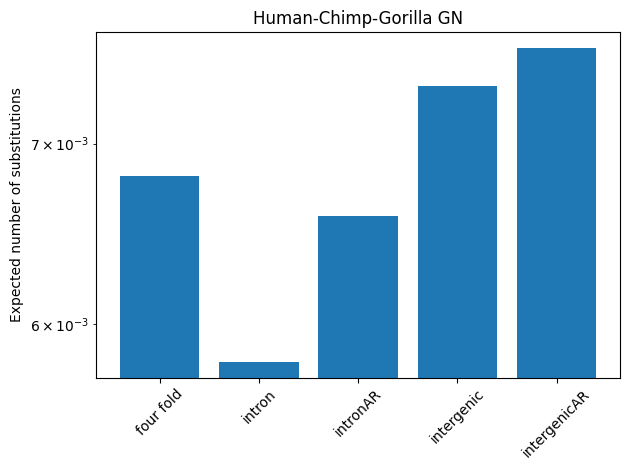

{'four fold': np.float64(0.00680712063781594), 'intron': np.float64(0.005807745101468988), 'intronAR': np.float64(0.006579164624861965), 'intergenic': np.float64(0.007351085200861113), 'intergenicAR': np.float64(0.0075960771350672045)}


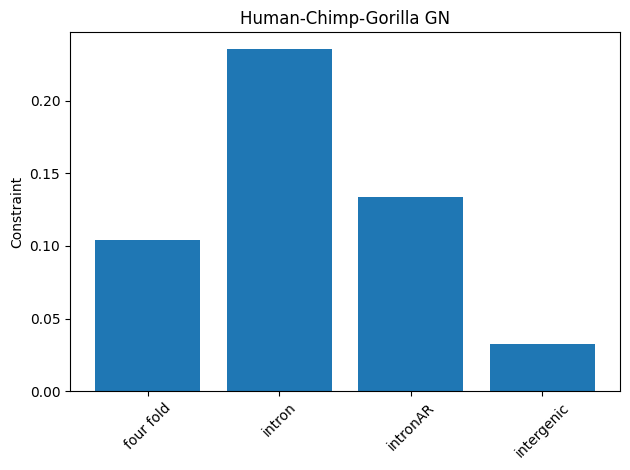

{'four fold': np.float64(0.103863676371723),
 'intron': np.float64(0.2354283667476732),
 'intronAR': np.float64(0.13387337860363135),
 'intergenic': np.float64(0.03225242843771148)}

In [22]:
ENS_human_GN = {
    "four fold": humanENS_ffold,
    "intron": humanENS_intron,
    "intronAR": humanENS_intronAR,
    "intergenic": humanENS_intergenic,
    "intergenicAR": humanENS_intergenicAR

}

constraint_GN = {
    "four fold": 1-humanENS_ffold/humanENS_intergenicAR,
    "intron": 1-humanENS_intron/humanENS_intergenicAR,
    "intronAR": 1-humanENS_intronAR/humanENS_intergenicAR,
    "intergenic": 1-humanENS_intergenic/humanENS_intergenicAR
}

plt.figure()
plt.bar(ENS_human_GN.keys(), ENS_human_GN.values())
plt.yscale("log")
plt.ylabel("Expected number of substitutions")
plt.title("Human-Chimp-Gorilla GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(ENS_human_GN)

plt.figure()
plt.bar(constraint_GN.keys(), constraint_GN.values())
plt.ylabel("Constraint")
plt.title("Human-Chimp-Gorilla GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

constraint_GN

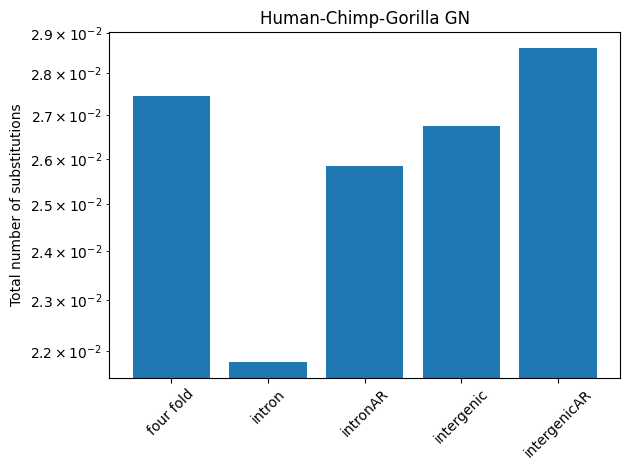

{'four fold': np.float64(0.027465077071970587), 'intron': np.float64(0.02179917641350483), 'intronAR': np.float64(0.025839087955766286), 'intergenic': np.float64(0.02674814947597449), 'intergenicAR': np.float64(0.028622953577162668)}


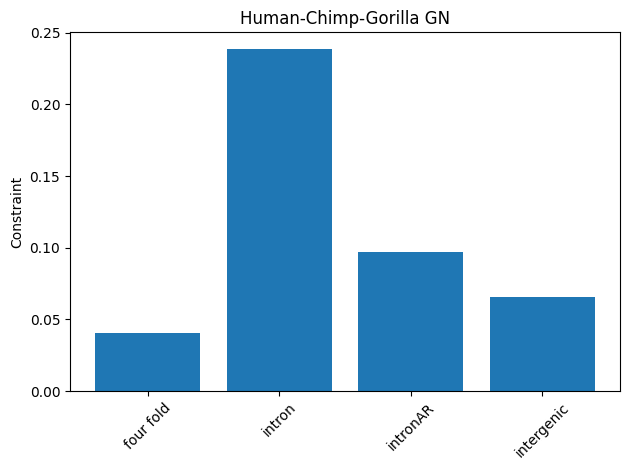

{'four fold': np.float64(0.040452726238424),
 'intron': np.float64(0.23840227198294128),
 'intronAR': np.float64(0.09725990065600842),
 'intergenic': np.float64(0.06550002242549913)}

In [24]:
totalENS_human_GN = {
    "four fold": totalENS_ffold,
    "intron": totalENS_introns,
    "intronAR": totalENS_intronsAR,
    "intergenic": totalENS_intergenic,
    "intergenicAR": totalENS_intergenicAR
}

totalENS_constraint_GN = {
    "four fold": 1-totalENS_ffold/totalENS_intergenicAR,
    "intron": 1-totalENS_introns/totalENS_intergenicAR,
    "intronAR": 1-totalENS_intronsAR/totalENS_intergenicAR,
    "intergenic": 1-totalENS_intergenic/totalENS_intergenicAR
}

plt.figure()
plt.bar(totalENS_human_GN.keys(), totalENS_human_GN.values())
plt.yscale("log")
plt.ylabel("Total number of substitutions")
plt.title("Human-Chimp-Gorilla GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(totalENS_human_GN)

plt.figure()
plt.bar(totalENS_constraint_GN.keys(), totalENS_constraint_GN.values())
plt.ylabel("Constraint")
plt.title("Human-Chimp-Gorilla GN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

totalENS_constraint_GN